In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import json

c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

In [4]:
max_samples = 100

data_name = "flash fiction"
data_locations = {
    "GPT-3": "../machine_data_stories/embeddings/GPT3_temp1.0_flash_fiction_nocrea100_vecs.json",
    "GPT-4": "../machine_data_stories/embeddings/GPT4_temp1.0_flash_fiction_nocrea100_vecs.json",
}

# data_name = "Haiku"
# data_locations = {
#     "GPT-3": "../machine_data_stories/embeddings/GPT3_temp1.0_haiku_nocrea100_vecs.json",
#     "GPT-4": "../machine_data_stories/embeddings/GPT4_temp1.0_haiku_nocrea100_vecs.json",
#     "Human": "../machine_data_stories/embeddings/human_haiku_tempslibres_vecs.json",
# }

data = {}
for name, loc in data_locations.items():
    data[name] = np.array(list(json.load(open(loc, "r")).values()))[:max_samples]

print("Number of samples per model:")
for name, vecs in data.items():
    print(name, vecs.shape[0])

Number of samples per model:
GPT-3 99
GPT-4 93


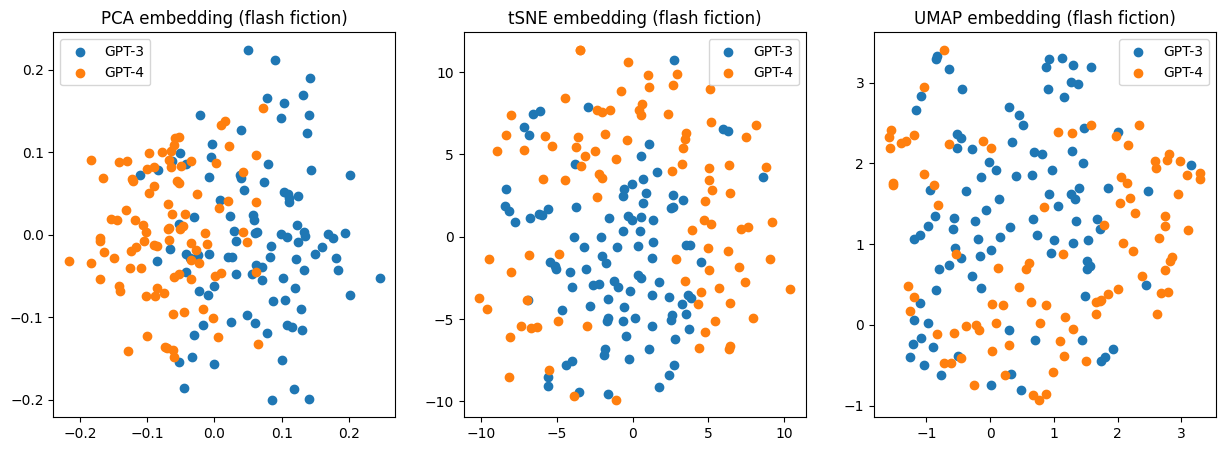

In [5]:
def plot_embedding(data, data_name, embedding_type="tSNE", show=True):
    vecs_all = np.concatenate(list(data.values()))
    model_ids = np.concatenate([[i] * len(vecs) for i, vecs in enumerate(data.values())])

    if embedding_type.lower() == "tsne":
        emb = TSNE(n_components=2)
    elif embedding_type.lower() == "pca":
        emb = PCA(n_components=2)
    elif embedding_type.lower() == "umap":
        emb = UMAP(n_components=2)
    else:
        raise ValueError(f"Unknown embedding type {embedding_type}")

    emb_vecs = emb.fit_transform(vecs_all)

    plt.title(f"{embedding_type} embedding ({data_name})")
    for i, name in enumerate(data.keys()):
        plt.scatter(*emb_vecs[model_ids == i].T, label=name)
    plt.legend()
    if show:
        plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(131)
plot_embedding(data, data_name, embedding_type="PCA", show=False)
plt.subplot(132)
plot_embedding(data, data_name, embedding_type="tSNE", show=False)
plt.subplot(133)
plot_embedding(data, data_name, embedding_type="UMAP", show=False)